In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import time
%matplotlib inline

from sklearn import datasets
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, completeness_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, accuracy_score

from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as SRP
from sklearn.ensemble import RandomForestClassifier as RF

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# load data
raw_data = load_breast_cancer()
X, y = raw_data.data, raw_data.target

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# normalize the input features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

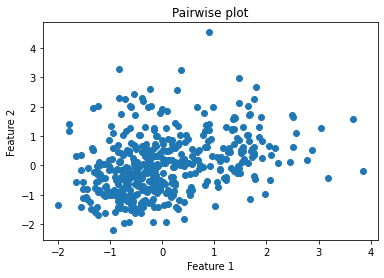

In [4]:
# pairwise plot two features
plt.scatter(X_train[:,0], X_train[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Pairwise plot')
plt.show() 

In [5]:
# check the correlations between features
df_x_train = pd.DataFrame(X_train)
corr = df_x_train.corr()
corr.shape

(30, 30)

In [6]:
# remove features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_x_train.columns[columns]
selected_columns.shape

(20,)

### K-means

In [7]:
# function to tune k for k-means
def k_means_tuning(title, X, n_components):
    sse = []
    for i in n_components:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    plt.plot(n_components, sse)
    plt.xlabel('Number of Components')
    plt.ylabel('SSE')
    plt.title(title)
    plt.grid()

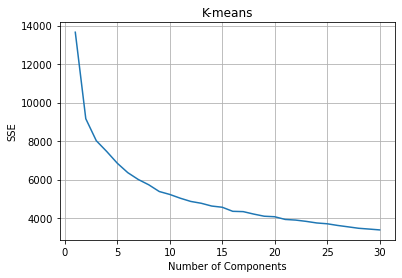

In [8]:
# parameter tuning k for k-means
k_means_tuning('K-means', X_train, range(1, 31))

In [9]:
# function to evaluate k-means
def k_means_scoring(title, X, y, n_components):
    sc = []
    ami = []
    hs = []
    auc = []
    
    for i in n_components:
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
        kmeans.fit(X)
        sc_score = silhouette_score(X, kmeans.labels_)
        sc.append(sc_score)
        ami_score = adjusted_mutual_info_score(y, kmeans.labels_)
        ami.append(ami_score)
        hs_score = homogeneity_score(y, kmeans.labels_)
        hs.append(hs_score)
        auc_score = accuracy_score(y, kmeans.labels_)
        auc.append(auc_score)
        
    plt.plot(n_components, sc, label='silhouette score')
    plt.plot(n_components, ami, label='ami score')
    plt.plot(n_components, hs, label='homogeneity score')
    plt.plot(n_components, auc, label='accuracy score')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid() 

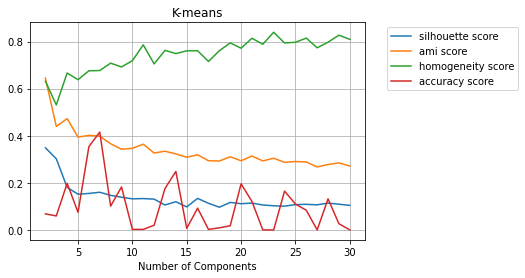

In [10]:
n_components = range(2, 31)
k_means_scoring('K-means', X_train, y_train, n_components)

In [11]:
# funtion to run k-means
def run_kmeans(X, n):
    kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(X)
    y_pred = kmeans.predict(X)
    return y_pred

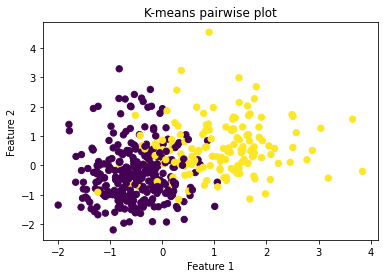

In [12]:
# k-means pairwise plot two features
y_pred = run_kmeans(X_train, 2)
def k_means_pairwise_plot(title, X, y_pred):
    plt.scatter(X[:,0], X[:,1], c=y_pred, s=40, cmap='viridis')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show() 
k_means_pairwise_plot('K-means pairwise plot', X_train, y_pred)

### Expectation Maximization

In [13]:
# function to tune number of components for em
def em_tuning(title, X, n_components):
    models = [GaussianMixture(n, covariance_type='tied', warm_start = True, random_state=42).fit(X)
          for n in n_components]

    plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
    plt.legend(loc='best')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid()

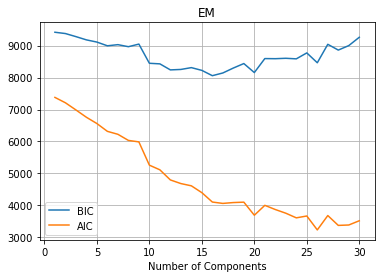

In [14]:
em_tuning('EM', X_train, range(1, 31))

In [15]:
# function to evaluate EM
def em_scoring(title, X, y, k_range):
    sc = []
    ami = []
    hs = []
    auc = []
   
    for i in k_range:
        gmm = GaussianMixture(i, covariance_type='tied', warm_start = True, random_state=42)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)
        sc_score = silhouette_score(X, gmm_labels)
        sc.append(sc_score)
        ami_score = adjusted_mutual_info_score(y, gmm_labels)
        ami.append(ami_score)
        hs_score = homogeneity_score(y, gmm_labels)
        hs.append(hs_score)
        auc_score = accuracy_score(y, gmm_labels)
        auc.append(auc_score)
        
    plt.plot(k_range, sc, label='silhouette score')
    plt.plot(k_range, ami, label='ami score')
    plt.plot(k_range, hs, label='homogeneity score')
    plt.plot(k_range, auc, label='accuracy score')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xlabel('Number of Components')
    plt.title(title)
    plt.grid() 

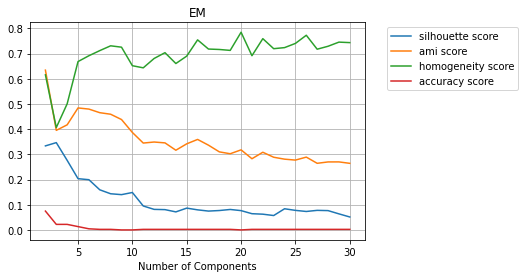

In [16]:
em_scoring('EM', X_train, y_train, n_components)

In [17]:
# funciton to run EM
def run_em(X, n):
    gmm = GaussianMixture(n, covariance_type='tied', warm_start = True, random_state=42)
    gmm.fit(X)
    gmm_labels = gmm.predict(X)
    return gmm_labels

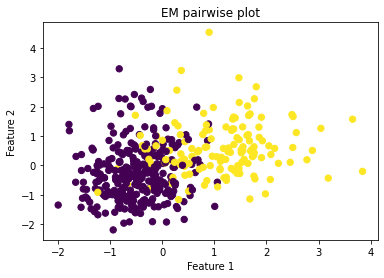

In [18]:
# EM pairwise plot two features
gmm_labels = run_em(X_train, 2)
def em_pairwise_plot(title, X, gmm_labels):
    plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, s=40, cmap='viridis')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
em_pairwise_plot('EM pairwise plot', X_train, gmm_labels)

### Dimensionality reduction

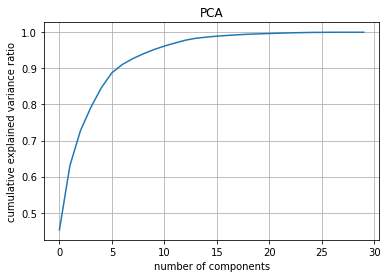

In [19]:
# PCA
pca = PCA(random_state=42).fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance ratio')
plt.title('PCA')
plt.grid()

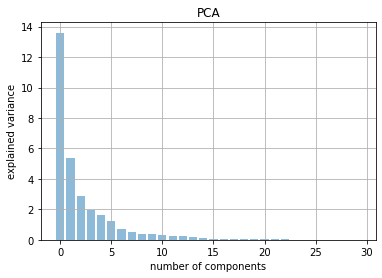

In [20]:
pca_variance = pca.explained_variance_
plt.bar(range(30), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('PCA')
plt.grid()

In [21]:
# Choose the number of components that capture 90% of the variance
n_pca = 5

# Transform the data
pca1 = PCA(n_components=n_pca, random_state=42)
X_trans_pca = pca1.fit_transform(X_train)
X_test_pca = pca1.fit_transform(X_test)

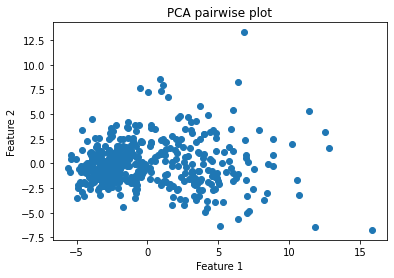

In [22]:
# pairwise plot two features
plt.scatter(X_trans_pca[:,0], X_trans_pca[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('PCA pairwise plot')
plt.show()

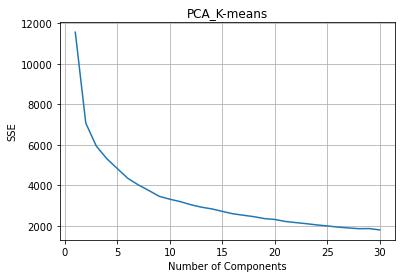

In [23]:
# PCA and k-means
k_means_tuning('PCA_K-means', X_trans_pca, range(1, 31))

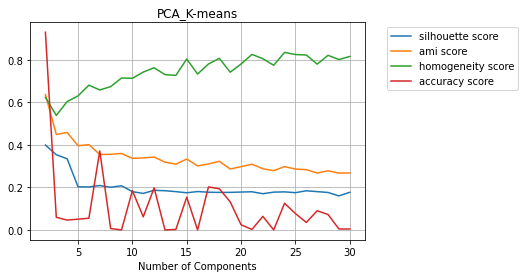

In [24]:
k_means_scoring('PCA_K-means', X_trans_pca, y_train, n_components)

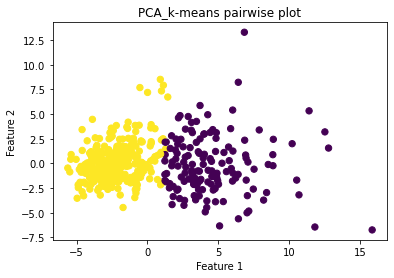

In [25]:
# choose number of clusters that has the highest sc 
y_pred_pca = run_kmeans(X_trans_pca, 2)
k_means_pairwise_plot('PCA_k-means pairwise plot', X_trans_pca, y_pred_pca)

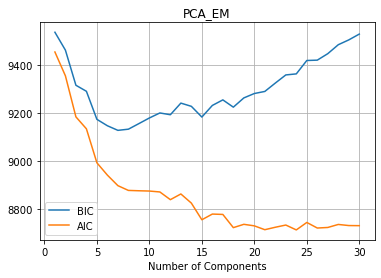

In [26]:
# PCA and EM
em_tuning('PCA_EM', X_trans_pca, range(1, 31))

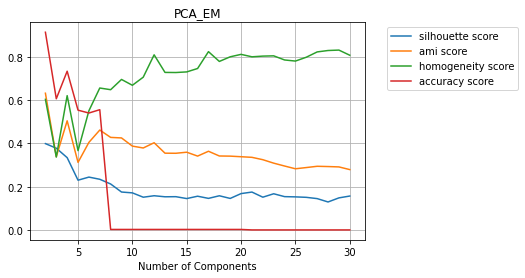

In [27]:
em_scoring('PCA_EM', X_trans_pca, y_train, n_components)

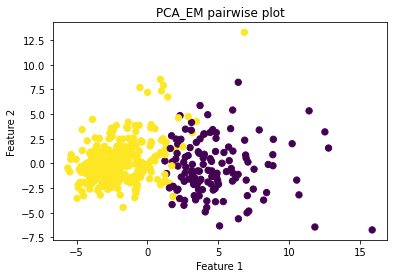

In [28]:
gmm_labels_pca = run_em(X_trans_pca, 2)
em_pairwise_plot('PCA_EM pairwise plot', X_trans_pca, gmm_labels_pca)

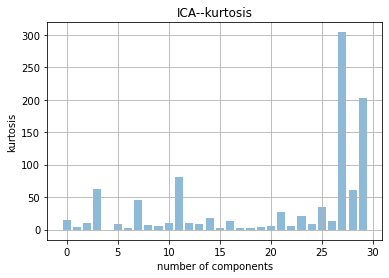

In [29]:
from scipy.stats import kurtosis
# Fit ICA
ica = ICA(whiten='arbitrary-variance', random_state=42)
X_ica = ica.fit_transform(X_train)  # Get the independent components

# Determine the number of components to use using the kurtosis criterion
kurtosis_scores = [kurtosis(X_ica[:, i]) for i in range(X_ica.shape[1])]
# plt.plot(kurtosis_scores)
plt.bar(range(30), kurtosis_scores, alpha=0.5, align='center', label='kurtosis')
plt.xlabel('number of components')
plt.ylabel('kurtosis')
plt.title('ICA--kurtosis')
plt.grid()
plt.show()

In [30]:
n_ica = 27
# Transform the data
ica1 = ICA(n_components=n_ica, whiten='arbitrary-variance', random_state=42)
X_trans_ica = ica1.fit_transform(X_train)
X_test_ica = ica1.fit_transform(X_test)

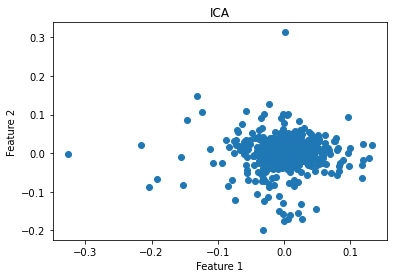

In [31]:
plt.scatter(X_trans_ica[:,0], X_trans_ica[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('ICA')
plt.show() 

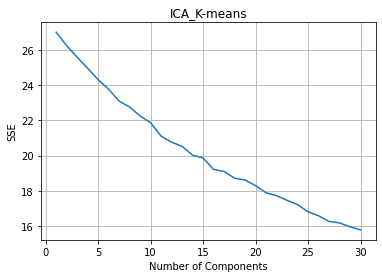

In [32]:
# ICA and k-means
k_means_tuning('ICA_K-means', X_trans_ica, range(1, 31))

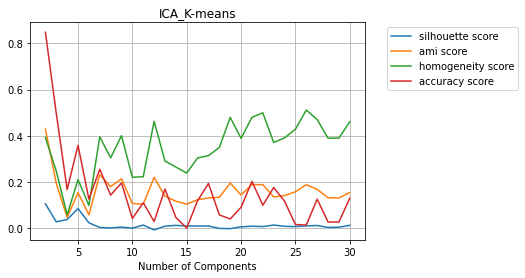

In [33]:
k_means_scoring('ICA_K-means', X_trans_ica, y_train, n_components)

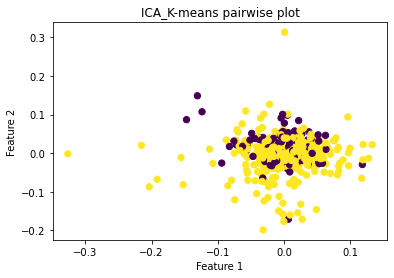

In [34]:
# choose number of clusters that has the highest sc 
y_pred_ica = run_kmeans(X_trans_ica, 2)
k_means_pairwise_plot('ICA_K-means pairwise plot', X_trans_ica, y_pred_ica)

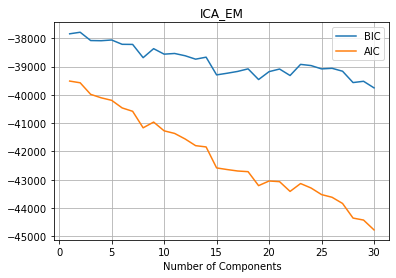

In [35]:
# ICA and EM
em_tuning('ICA_EM', X_trans_ica, range(1, 31))

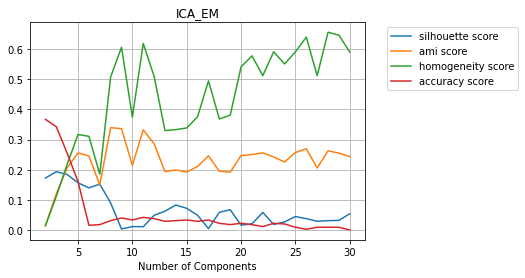

In [36]:
em_scoring('ICA_EM', X_trans_ica, y_train, n_components)

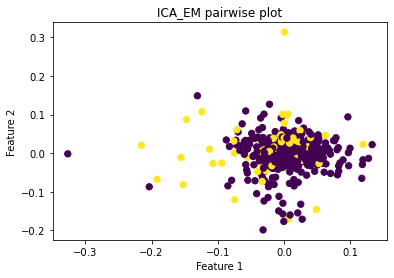

In [37]:
gmm_labels_ica = run_em(X_trans_ica, 2)
em_pairwise_plot('ICA_EM pairwise plot', X_trans_ica, gmm_labels_ica)

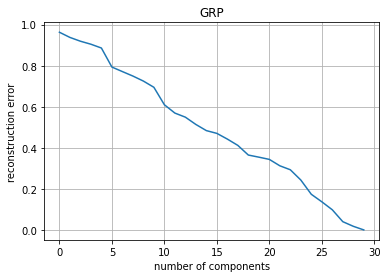

In [38]:
# GRP
reconstruction_error = []
for n in range(1, 31):
    grp = GRP(n_components=n, compute_inverse_components=True, random_state=42)
    X_grp = grp.fit_transform(X_train)
    X_grp_inverse = grp.inverse_transform(X_grp)
    reconstruction_error.append(((X_train - X_grp_inverse) ** 2).mean())
plt.plot(reconstruction_error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('GRP')
plt.grid()
plt.show()

In [39]:
grp = GRP(n_components=25, compute_inverse_components=True, random_state=42)
X_trans_grp = grp.fit_transform(X_train)
X_test_grp = grp.fit_transform(X_test)

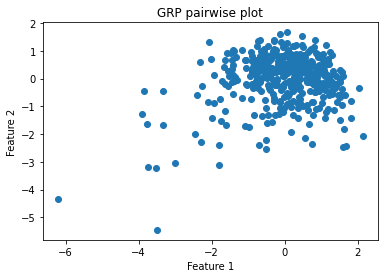

In [40]:
plt.scatter(X_trans_grp[:,0], X_trans_grp[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GRP pairwise plot')
plt.show()

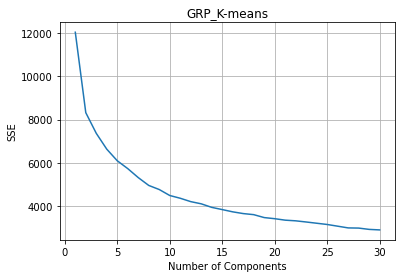

In [41]:
# GRP and k-means
k_means_tuning('GRP_K-means', X_trans_grp, range(1, 31))

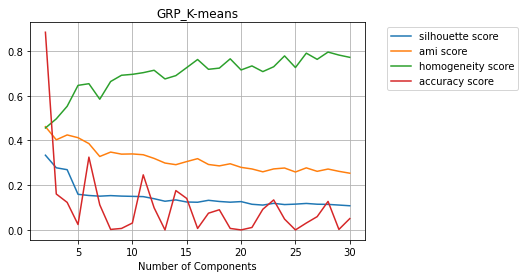

In [42]:
k_means_scoring('GRP_K-means', X_trans_grp, y_train, n_components)

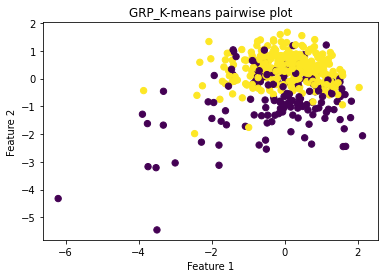

In [43]:
# choose number of clusters that has the highest sc 
y_pred_grp = run_kmeans(X_trans_grp, 2)
k_means_pairwise_plot('GRP_K-means pairwise plot', X_trans_grp, y_pred_grp)

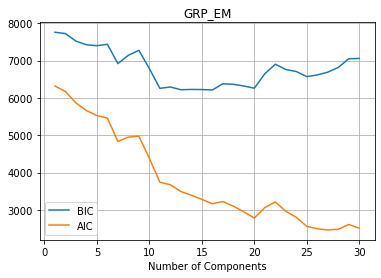

In [44]:
# GRP and EM
em_tuning('GRP_EM', X_trans_grp, range(1, 31))

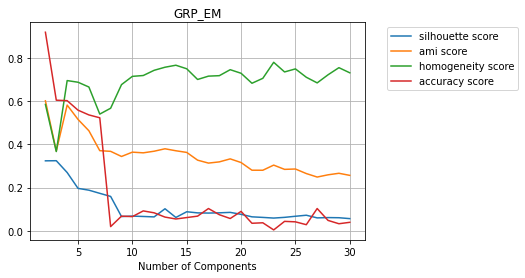

In [45]:
em_scoring('GRP_EM', X_trans_grp, y_train, n_components)

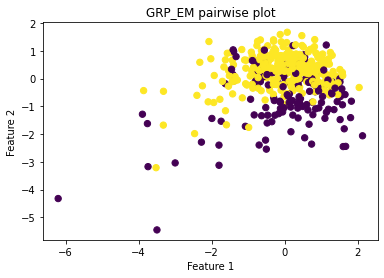

In [46]:
gmm_labels_grp = run_em(X_trans_grp, 2)
em_pairwise_plot('GRP_EM pairwise plot', X_trans_grp, gmm_labels_grp)

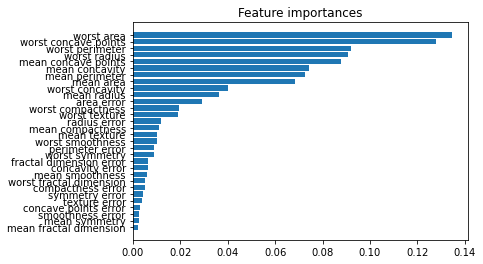

In [47]:
# Random forest--feature selection
rf = RF(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
features = raw_data.feature_names
feature_imp = rf.feature_importances_
f_i = list(zip(features, feature_imp))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
plt.title('Feature importances')
plt.show()

In [48]:
# feature selection (drop features importance less than 0.05)
feature_df = pd.DataFrame(feature_imp, columns=['feature importance'], index=raw_data.feature_names)
top_feature_df = feature_df[feature_df['feature importance'] >= 0.05]
index = top_feature_df.index.tolist()
rfc_X_train_ = pd.DataFrame(X_train, columns=raw_data.feature_names)
rfc_X_test = pd.DataFrame(X_test, columns=raw_data.feature_names)
rfc_df = rfc_X_train_[index]
rfc_test_df = rfc_X_test[index]
rfc_train = np.array(rfc_df)
rfc_test = np.array(rfc_test_df)

In [49]:
rfc_df.head()

,mean perimeter,mean area,mean concavity,mean concave points,worst radius,worst perimeter,worst area,worst concave points
0,1.010448,0.903128,0.379781,0.981747,0.932100,0.857380,0.754906,1.218398
1,1.703381,1.746022,1.351402,1.389686,1.223617,1.262419,1.135042,0.697164
2,-1.450464,-1.154826,-1.072274,-1.171440,-1.340339,-1.360278,-1.033921,-1.522338
3,-0.552455,-0.559306,-0.265180,-0.615972,-0.655273,-0.591854,-0.622836,-0.364720
4,-0.572082,-0.539704,-0.855138,-0.737897,-0.645289,-0.693544,-0.617453,-1.013948


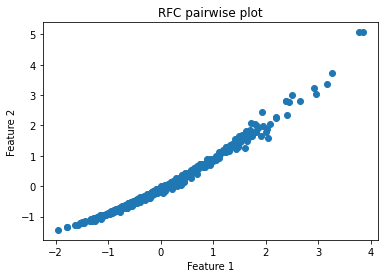

In [50]:
# pairwise plot two features
plt.scatter(rfc_train[:,0], rfc_train[:,1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RFC pairwise plot')
plt.show()

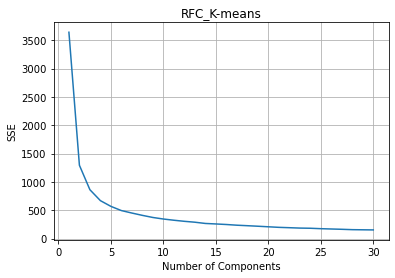

In [51]:
# RFC and kmeans
rfc_n = range(2, 11)
k_means_tuning('RFC_K-means', rfc_train, range(1, 31))

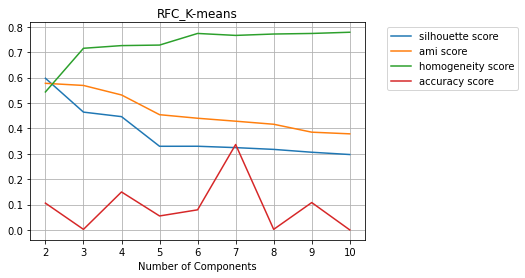

In [52]:
k_means_scoring('RFC_K-means', rfc_train, y_train, rfc_n)

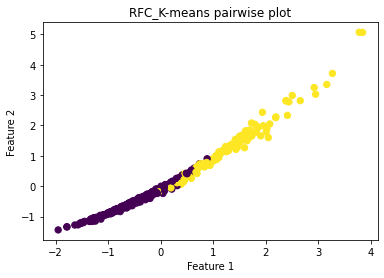

In [53]:
# choose number of clusters that has the highest sc 
y_pred_rfc = run_kmeans(rfc_train, 2)
k_means_pairwise_plot('RFC_K-means pairwise plot', rfc_train, y_pred_rfc)

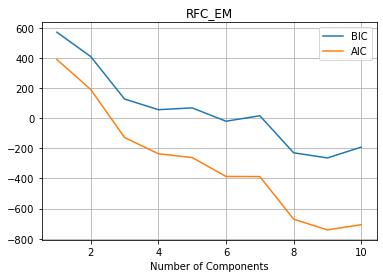

In [54]:
# RFC and EM
em_tuning('RFC_EM', rfc_train, range(1, 11))

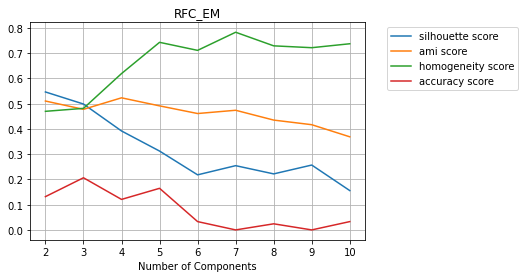

In [55]:
em_scoring('RFC_EM', rfc_train, y_train, rfc_n)

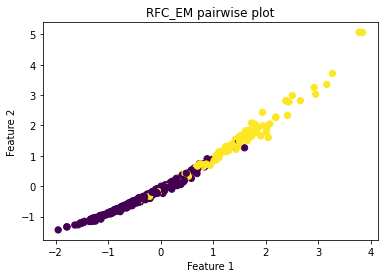

In [56]:
gmm_labels_rfc = run_em(rfc_train, 2)
em_pairwise_plot('RFC_EM pairwise plot', rfc_train, gmm_labels_rfc)